In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

In [10]:
bird_names = ["Black-naped Oriole", "Brown-throated Sunbird", "Collared Kingfisher", "Javan Myna", "Olive-backed Sunbird", "Pink-necked Green Pigeon", "Spotted Dove", "Striated Heron", "White-breasted Waterhen", "Yellow-vented Bulbul"]
#bird_names = ["Black-naped Oriole"]
NUM_CLASSES = 10
IMAGE_SIZE = 224

bounding_box_dir = "data/Bounding Boxes/"

bounding_box_dfs = []
for bird_name in bird_names:
    bounding_box_csv_path = bounding_box_dir + bird_name + ".csv"
    bounding_box_df = pd.read_csv(bounding_box_csv_path)
    bounding_box_dfs.append(bounding_box_df)

In [34]:
bounding_box_dfs[7]

,label,top_left_x,top_left_y,width,height,image_name,image_width,image_height
0,Striated Heron,3,69,201,90,Striated Heron-0.png,224,224
1,Striated Heron,74,85,100,62,Striated Heron-1.png,224,224
2,Striated Heron,147,68,42,76,Striated Heron-10.png,224,224
3,Striated Heron,30,35,163,166,Striated Heron-100.png,224,224
4,Striated Heron,64,65,101,101,Striated Heron-103.png,224,224
...,...,...,...,...,...,...,...,...
95,Striated Heron,28,45,169,108,Striated Heron-95.png,224,224
96,Striated Heron,43,28,148,170,Striated Heron-96.png,224,224
97,Striated Heron,65,105,63,95,Striated Heron-97.png,224,224
98,Striated Heron,74,101,35,27,Striated Heron-98.png,224,224


## Bounding Box Characteristics by Class

First, we plot the height and width distribution of the bounding boxes for each of the individual classes, because we know that basic CNNs are not scale-invariant. Hence, the model may struggle with instances with an uncommon height and width combination (i.e. outliers)

### Plot Size Distribution of Bounding Boxes

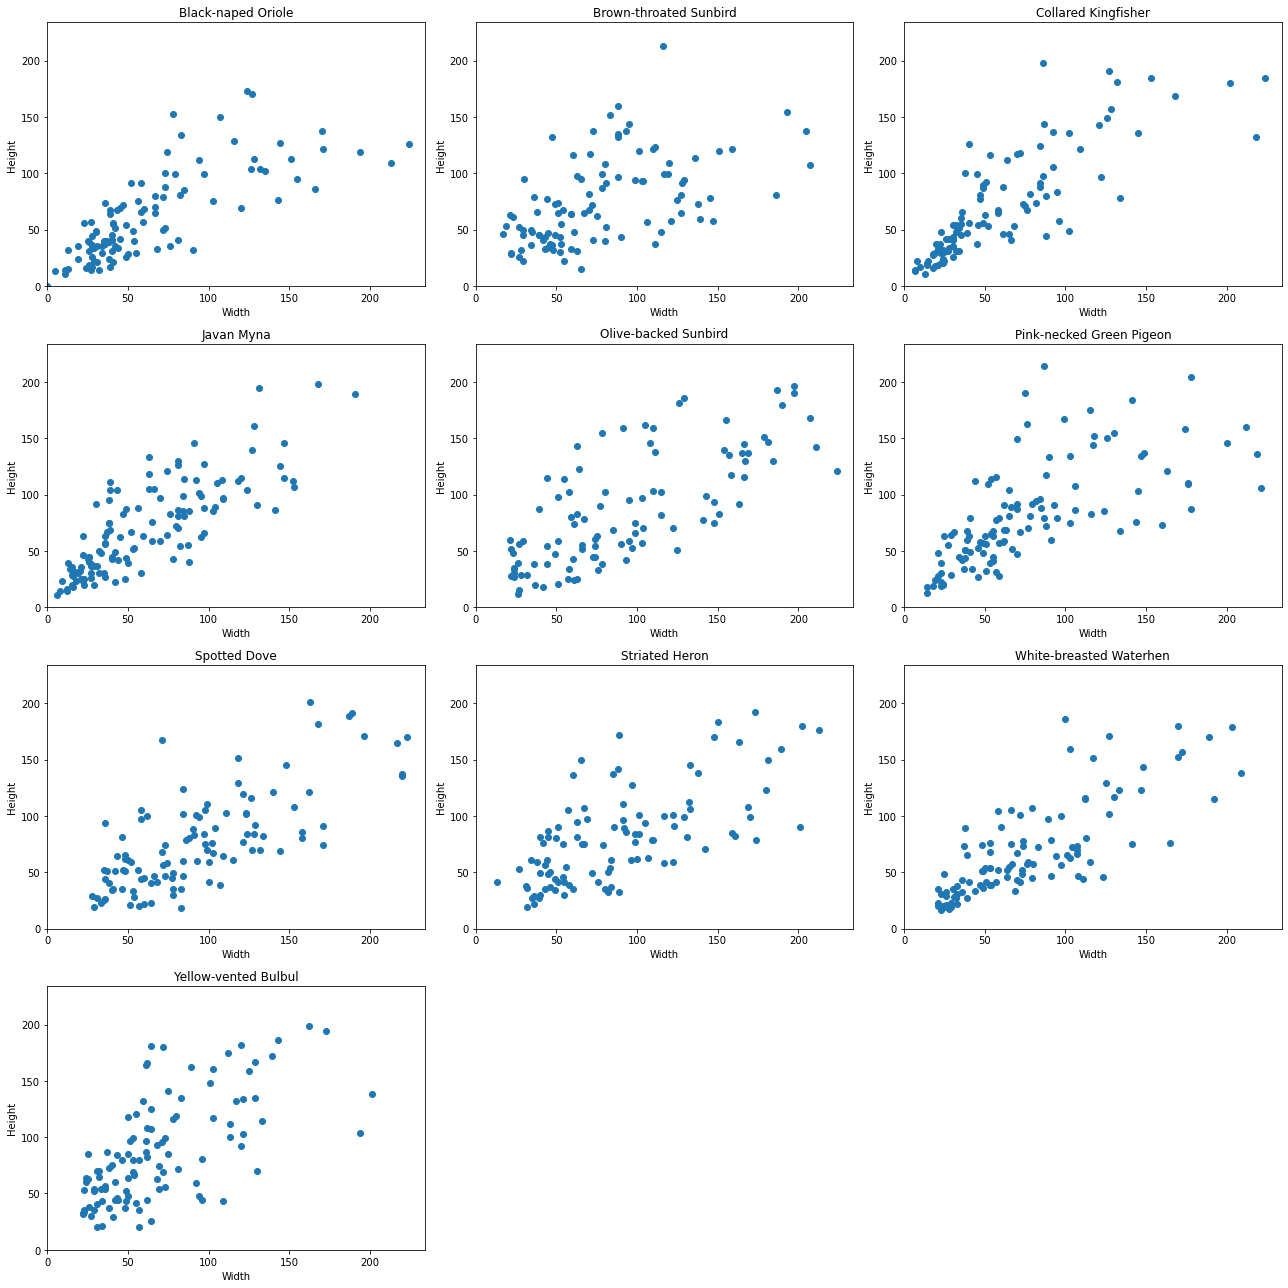

In [15]:
fig = plt.figure(figsize=(18,18))

# Plot distribution for individual classes
for i in range(NUM_CLASSES):
    bird_name = bird_names[i]
    bounding_box_df = bounding_box_dfs[i]
    
    fig.add_subplot(4, 3, i+1)
    plt.scatter(x = bounding_box_df.loc[:,"width"], y = bounding_box_df.loc[:,"height"])
    #plt.hist2d(bounding_box_df.loc[:, "width"], bounding_box_df.loc[:, "height"], bins = 10)
    plt.title(bird_name)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.xlim([0, IMAGE_SIZE+10])
    plt.ylim([0, IMAGE_SIZE+10])

fig.tight_layout()
plt.show()

We can see that the majority of classes have the height and width of bounding boxes clustered around the 25-75 size range. We predict that the model will perform better for objects within that range.

Interestingly, some classes have a wider size distribution than others e.g. Striated Heron vs Black-naped Oriole, making those more challenging for the model which is not scale-invariant.

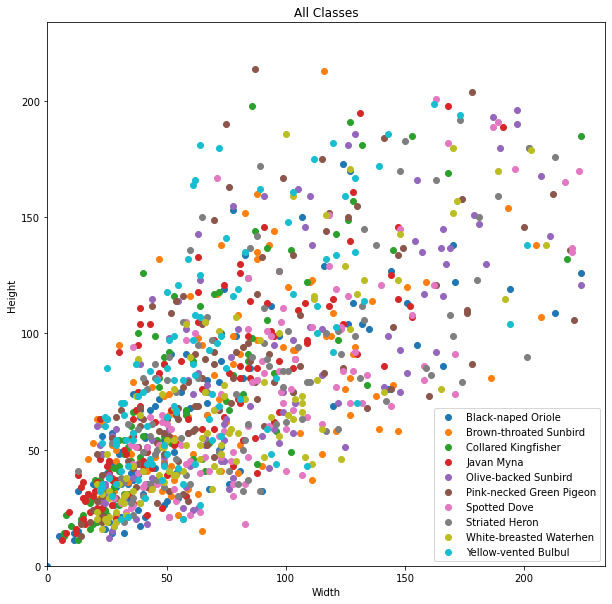

In [16]:
# Plot combined distribution
fig = plt.figure(figsize=(10,10))

for i in range(NUM_CLASSES):
    bird_name = bird_names[i]
    bounding_box_df = bounding_box_dfs[i]
    
    plt.scatter(x = bounding_box_df.loc[:,"width"], y = bounding_box_df.loc[:,"height"])
    
plt.title("All Classes")
plt.xlabel("Width")
plt.ylabel("Height")
plt.xlim([0, IMAGE_SIZE+10])
plt.ylim([0, IMAGE_SIZE+10])
plt.legend(bird_names)

plt.show()

From this we can see that the distribution of height and width is not drastically different between classes, and is mostly concentrated between 25-75 pixels wide/high. Ideally, this will help the model in training so long as it can generalize information about what a bird looks like.

In [29]:
bounding_box_dfs[7].describe().loc[:,("width", "height")]

,width,height
count,100.000000,100.000000
mean,89.130000,81.360000
std,47.346489,41.946941
min,13.000000,19.000000
25%,49.750000,48.750000
50%,82.500000,79.000000
75%,118.250000,100.250000
max,213.000000,192.000000


TODO: Plot summary statistics for bounding boxes on a scatter plot? or box-and-whiskers?

If one class has larger images on avg, so what? Perhaps the concern is the variance?

### Plot Spatial Distribution of Bounding Boxes (heatmaps)

Next, we plot a heatmap of the spatial distribution of the bounding boxes, to get a sense of whether there is a bias in where the bounding boxes are located on the average image.

Prior knowledge tells us that the bounding boxes are likely to be clustered at the center of the image, as that is how people usually take their photographs.

Why is this important? 

_Might_ be useful when generating region proposals, or when considering which anchor points to use in the image rather than brute-forcing everything, which may slow things down. (but need to be careful about test data leakage because we are using the entire dataset for EDA)

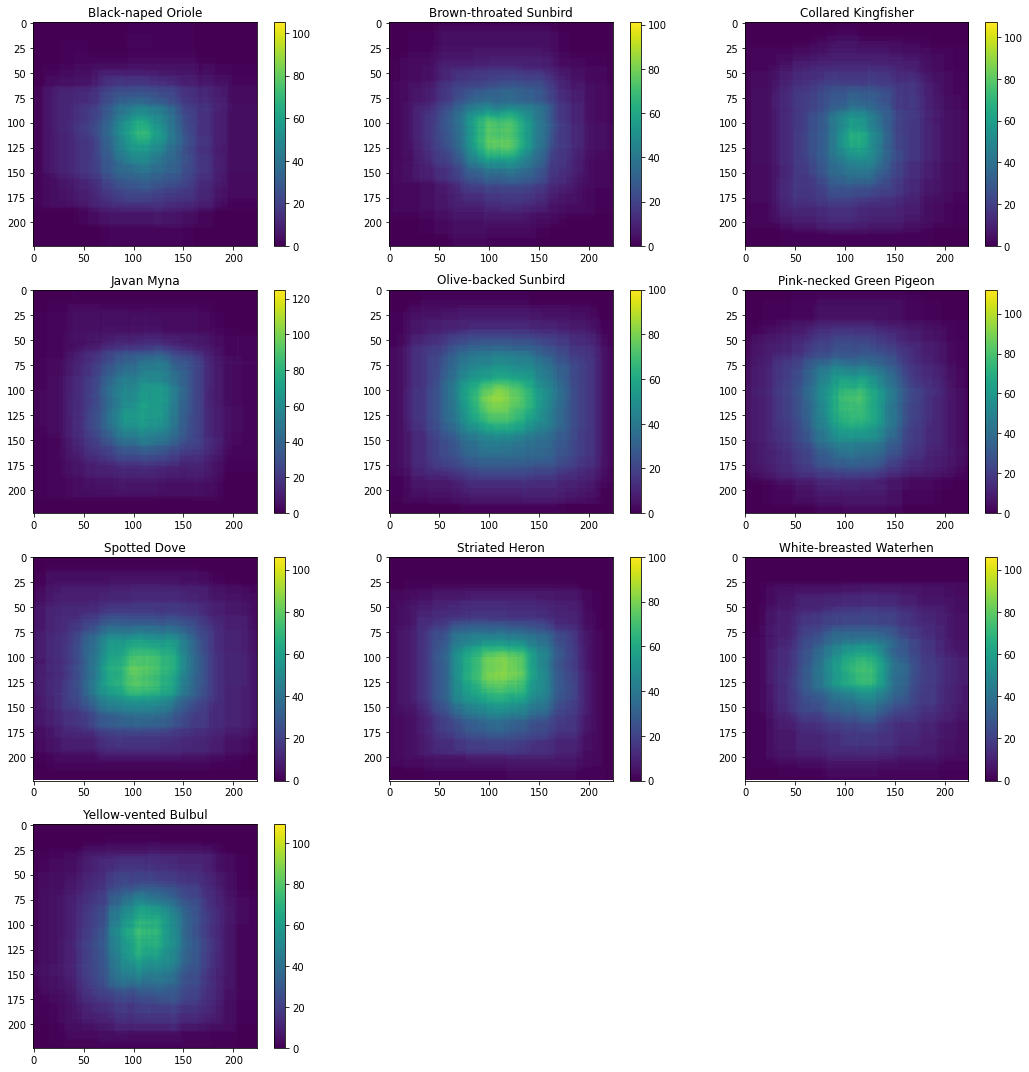

In [43]:
fig = plt.figure(figsize=(15,15))

for i in range(NUM_CLASSES):
    bb_cumulative_heatmap = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
    bird_name = bird_names[i]
    bb_df = bounding_box_dfs[i]
    
    # Build up heatmap
    for index, row in bb_df.iterrows():
        top_left_x = row['top_left_x']
        top_left_y = row['top_left_y']
        width = row['width']
        height = row['height']
        
        bb_cumulative_heatmap[top_left_y:top_left_y + height, top_left_x:top_left_x + width] += 1
                
    fig.add_subplot(4, 3, i+1)
    plt.imshow(bb_cumulative_heatmap)
    plt.colorbar()
    num_bb_in_class = bb_df.shape[0]
    plt.clim(0, num_bb_in_class)
    plt.title(bird_name)
        
fig.tight_layout()
plt.show()
    

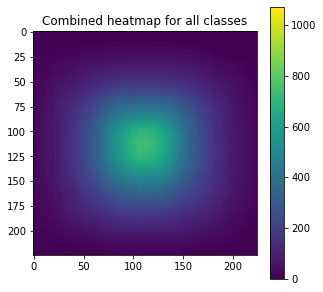

In [44]:
# Combined heatmap for all images
fig = plt.figure(figsize=(5,5))
bb_cumulative_heatmap = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
total_num_bb = 0

for i in range(NUM_CLASSES):
    bb_df = bounding_box_dfs[i]
    total_num_bb += bb_df.shape[0]
    
    # Build up heatmap
    for index, row in bb_df.iterrows():
        top_left_x = row['top_left_x']
        top_left_y = row['top_left_y']
        width = row['width']
        height = row['height']
        
        bb_cumulative_heatmap[top_left_y:top_left_y + height, top_left_x:top_left_x + width] += 1
                
plt.imshow(bb_cumulative_heatmap)
plt.colorbar()
plt.clim(0, total_num_bb)
plt.title("Combined heatmap for all classes")
plt.show()

Conclusions: Most bounding boxes can be found distributed about the center of the image, as expected.

### Number of Classes Per Image

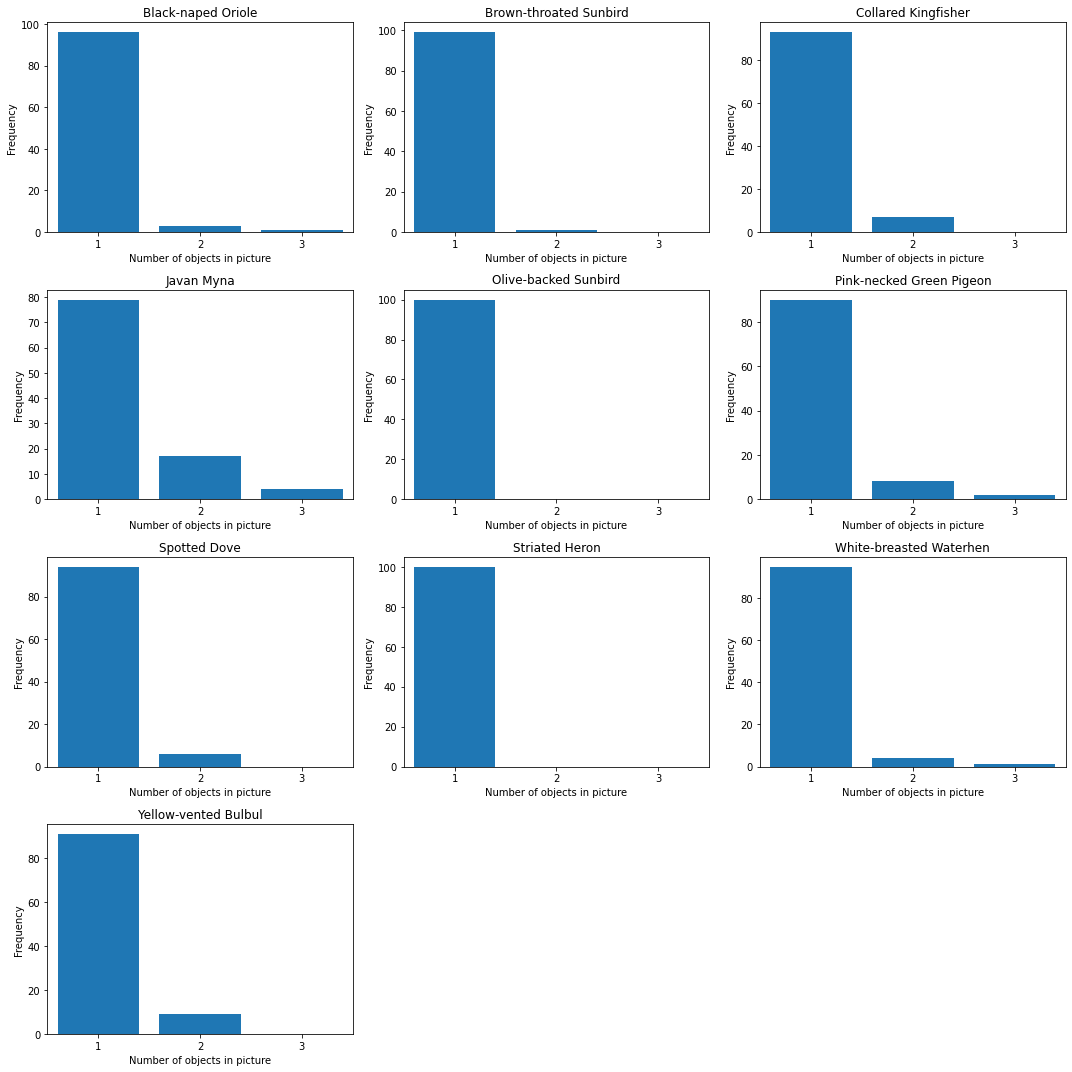

In [94]:
fig = plt.figure(figsize=(15,15))

for i in range(NUM_CLASSES):
    bb_df = bounding_box_dfs[i]
    bird_name = bird_names[i]
    bb_counts_per_image = bb_df['image_name'].value_counts().value_counts()
    
    fig.add_subplot(4, 3, i+1)
    plt.bar(bb_counts_per_image.index, bb_counts_per_image)
    plt.locator_params(tight = True, integer=True)
    plt.xlim((0.5, 3.5))
    plt.xlabel("Number of objects in picture")
    plt.ylabel("Frequency")
    plt.title(bird_name)
        
fig.tight_layout()
plt.show()

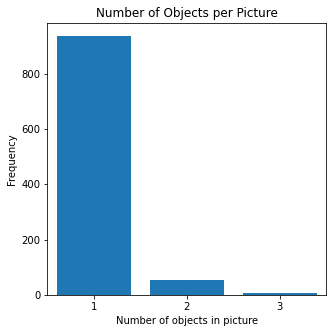

In [96]:
fig = plt.figure(figsize=(5, 5))

bb_counts_per_image = pd.Series({1:0, 2:0, 3:0})

for i in range(NUM_CLASSES):
    bb_df = bounding_box_dfs[i]
    bird_name = bird_names[i]
    bb_counts_per_image = bb_counts_per_image.add(bb_df['image_name'].value_counts().value_counts(), fill_value = 0)
    
plt.bar(bb_counts_per_image.index, bb_counts_per_image)
plt.locator_params(tight = True, integer=True)
plt.xlim((0.5, 3.5))
plt.title("Number of Objects per Picture")
plt.xlabel("Number of objects in picture")
plt.ylabel("Frequency")

plt.show()

Clearly, most pictures only have a single object, and very rarely have two or three objects.

## Image Distribution by Class

### Compare Distribution of the different images

### Ensuring that training and test data have similar distributions

## Train-Test Split

Limitations:
* Images only contain a single class, and not >1 class